## Initial setup

In [35]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
#export
from exp.nb_02 import *
import torch.nn.functional as F

## Get the MNIST Data

In [37]:
# set matplotlib color map
mpl.rcParams['image.cmap'] = 'gray'

In [38]:
# split data into training and validation sets
x_train,y_train,x_valid,y_valid = get_data()

In [39]:
# rows and columns of training data
n,m = x_train.shape
# number of possible output labels
c = y_train.max()+1
# size of the hidden layer
nh = 50

In [40]:
# simple fully connected network
class Model(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,n_hidden), nn.ReLU(), nn.Linear(n_hidden,n_out)]
    # sequentially apply layers and return the output activations
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [41]:
# instantiate the model
model = Model(n_in = m, n_hidden = nh, n_out = 10)

In [42]:
# predict training labels
pred = model(x_train)

# look at the output activations for the first training example
import numpy as np
pred.detach().numpy()[0]

array([-0.257343,  0.175739, -0.094756,  0.056049,  0.105757,  0.149626, -0.056244, -0.136575,  0.021842,  0.181934],
      dtype=float32)

## Softmax

Cross-entropy loss is the usual loss function for multi-label classification problems. Since cross-entropy loss is computed from the probabilities of the predicted classes, we must first convert the output activations to probabilities; this is accomplished by applying the softmax function to the output activations.

Softmax is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In the above formulas, $i$ indexes the output activation node.

In practice, we will need the log of the softmax when we calculate the loss.

In [43]:
# compute log(softmax)
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [44]:
# applying softmax to the output activations converts them to log probabilities
sm_pred = log_softmax(pred)
print('\nshape ',sm_pred.shape)

# look at the first example in the training set
print('\noutput log probabilities: ',sm_pred.detach().numpy()[1,:])
print('\noutput probabilities: ',np.exp(sm_pred.detach().numpy()[1,:]))

# check that sum of probabilities is one
print('\nsum of probabilities is ',np.exp(sm_pred.detach().numpy()[1,:]).sum())

# the predicted digit is the output with the highest probability
print('\npredicted digit is ',np.argmax(np.exp(sm_pred.detach().numpy()[1,:])))


shape  torch.Size([50000, 10])

output log probabilities:  [-2.512025 -2.189113 -2.35568  -2.329506 -2.265454 -2.239702 -2.441702 -2.420158 -2.27286  -2.075474]

output probabilities:  [0.081104 0.112016 0.094829 0.097344 0.103783 0.10649  0.087013 0.088908 0.103017 0.125497]

sum of probabilities is  1.0

predicted digit is  9


## Cross-Entropy Loss
The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ \ell = -\sum x\, \log p(x)$$

But since our $x$s are 1-hot encoded, this can be rewritten as 

$$ \ell = -\log(p_{i})$$
where $i$ is the index of the true class label.

And the loss function is the mean cross-entropy loss over all the examples:

$$\mathcal{L} = \frac{\sum \ell}{N}$$
where $N$ is the number of examples in the training data set.

We can implement the cross-entropy loss function using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link. 

The next few cells provide examples of indexing, then we'll go on to implement the cross-entropy loss function.

In [45]:
# shapes of training set predictions output and of the training labels
print('\ny_train (target) shape is ',y_train.shape)
print('\nsm_pred (input) shape is ',sm_pred.shape)


y_train (target) shape is  torch.Size([50000])

sm_pred (input) shape is  torch.Size([50000, 10])


In [46]:
# indexing, example 1
y_train[:3]

tensor([5, 0, 4])

In [47]:
# indexing, example 2
print(sm_pred[[0,1,2], [5,0,4]]) 
print(sm_pred[0][5])
print(sm_pred[1][0])
print(sm_pred[2][4])

tensor([-2.1771, -2.5120, -2.2751], grad_fn=<IndexBackward>)
tensor(-2.1771, grad_fn=<SelectBackward>)
tensor(-2.5120, grad_fn=<SelectBackward>)
tensor(-2.2751, grad_fn=<SelectBackward>)


In [48]:
# indexing, example 3
print(sm_pred[[0,1,2], :6])
print(sm_pred[0,:6])
print(sm_pred[1,:6])
print(sm_pred[2,:6])
# print(sm_pred[[0,1,2], 5])

tensor([[-2.5841, -2.1510, -2.4215, -2.2707, -2.2210, -2.1771],
        [-2.5120, -2.1891, -2.3557, -2.3295, -2.2655, -2.2397],
        [-2.3701, -2.2439, -2.4979, -2.4473, -2.2751, -2.1601]],
       grad_fn=<IndexBackward>)
tensor([-2.5841, -2.1510, -2.4215, -2.2707, -2.2210, -2.1771],
       grad_fn=<SliceBackward>)
tensor([-2.5120, -2.1891, -2.3557, -2.3295, -2.2655, -2.2397],
       grad_fn=<SliceBackward>)
tensor([-2.3701, -2.2439, -2.4979, -2.4473, -2.2751, -2.1601],
       grad_fn=<SliceBackward>)


In [49]:
# nll (negative log likelihood) loss function
#    nll is our implementation of the cross-entropy loss function
#    -- computes a vector of the predicted log probabilities corresponding to the true labels for each example
#    -- outputs the negative mean of this vector, which is the cross-entropy loss function
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [50]:
# evaluate the nll (or cross-entropy) loss function
loss = nll(sm_pred, y_train)
print(loss)

tensor(2.3207, grad_fn=<NegBackward>)


Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [51]:
# refactor log_softmax
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [52]:
# check that nll using the refactored log_softmax is the same as before
test_near(nll(log_softmax(pred), y_train), loss)

There's a problem with the logsumexp function: overflow can occur if the exponents become large positive numbers. 
The [LogSumExp trick] provides a brilliant way to compute the log of the sum of exponentials in a more stable way. (https://en.wikipedia.org/wiki/LogSumExp). The idea is to express logsumexp in the following way:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where $a$ is the maximum of the $x_{j}$.

Note that because of the clever choice of $a$, all the exponents on the right-hand side are $\le 0$. Recall that the exponential of a negative number is always a positive number that is less than $1$. So the expression on the right hand side contains no exponentials of large positive numbers. This solves the overflow problem!

In [53]:
# implement the LogSumExp trick for numerical stability
def logsumexp(x):
    # index (-1) indicates the last dimension, in this case, it's the same as (1), which is across rows
    # but pytorch max returns a vector of values and also a vector of the column indices corresponding to those values 
    # the [0] at the end of the line below is necessary to select the values
    m = x.max(-1)[0]
    # m is a vector; to convert it to a column vector, i.e. a matrix with one column, use m[:,None] 
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [54]:
# verify equivalence between our logsumexp function and python's implementation
test_near(logsumexp(pred), pred.logsumexp(-1))

So we can use it for our `log_softmax` function.

In [55]:
# refactor log_softmax again
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [56]:
# verify equivalence of nll and loss
test_near(nll(log_softmax(pred), y_train), loss)

Then use PyTorch's implementation of nll_loss:

In [57]:
# verify equivalence of pytorch's implementation of nll and loss
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [58]:
# verify equivalence of python's corss-entropy and loss
test_near(F.cross_entropy(pred, y_train), loss)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [59]:
# we are allowed to use Pytorch implementation of loss function
#    inputs preds, labels
#    where preds are the activation outputs
loss_func = F.cross_entropy

In [60]:
# accuracy is the fraction of correct predictions
# predicted class is torch.argmax(prediction_probs, dim=1)==target)
def accuracy(prediction_probs, target): return (torch.argmax(prediction_probs, dim=1)==target).float().mean()

In [61]:
# define a mini-batch and run the model to get predictions
bs=64                  # batch size
xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions (activation outputs)
preds[0], preds.shape

(tensor([-0.2573,  0.1757, -0.0948,  0.0560,  0.1058,  0.1496, -0.0562, -0.1366,
          0.0218,  0.1819], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [62]:
# calculate the loss function
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3126, grad_fn=<NllLossBackward>)

In [63]:
# calculate the accuracy for a forward pass on a single batch
accuracy(preds, yb)

tensor(0.0781)

In [64]:
# set the hyperparameters
lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

In [65]:
# initial training loop
def fit(model,loss_func,epochs,bs,lr,n,x_train,y_train):
    # loop over epochs; an epoch consists of all n samples
    for epoch in range(epochs):
        # loop over batches; a batch is a subset of samples specified by bs, e.g., 64 samples if bs = 64
        #   batch index goes from 0 to (n-1)/bs + 1, so the last batch can have fewer than bs samples
        for i in range((n-1)//bs + 1):
            # set_trace()
            # index of first sample in batch number i 
            start_i = i*bs
            # index after last sample in batch number i
            end_i = start_i+bs
            # get the current batch
            xb = x_train[start_i:end_i] # data points
            yb = y_train[start_i:end_i] # labels
            # make a forward pass, then compute the loss function
            loss = loss_func(model(xb), yb)
            # compute the gradients of the loss function with respect to the parameters in each layer
            loss.backward()
            # loop over the layers, applying updates for each parameter
            #   temporarily set requires_grad flags (whose default values are True) to False,
            #      since we don't want to track the gradients while we are making empirical updates
            #   after the updates, reset the gradients to zero to prepare for the next batch
            with torch.no_grad(): 
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        # update the weights and biases using SGD
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad   * lr
                        # zero the gradients
                        l.weight.grad.zero_()
                        l.bias  .grad.zero_()

In [66]:
# a linear layer has weight and bias
print(hasattr(nn.Linear(nh,c.numpy()),'weight'),hasattr(nn.Linear(nh,c.numpy()),'bias'))

True True


In [67]:
# a ReLU layer has no parameters
print(hasattr(nn.ReLU(),'weight'),hasattr(nn.ReLU(),'bias'))

False False


In [68]:
# train the model for 1 epoch
fit(model,loss_func,epochs,bs,lr,n,x_train,y_train)
# loss function and accuracy after 1 epoch of training with bs = 64 and lr = 0.5
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1168, grad_fn=<NllLossBackward>), tensor(0.9531))

## Using parameters and optim

### Parameters

Use `nn.Module.__setattr__` and move relu to functional:

In [69]:
# original version of Model(), the starting point for refactoring
class Model(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        # inherits from nn.Module, and super().__init__() allows access to all the methods and attributes of nn.Module
        super().__init__()
        self.layers = [nn.Linear(n_in,n_hidden), nn.ReLU(), nn.Linear(n_hidden,n_out)]
    # sequentially apply layers and return the output activations
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [70]:
# refactor Model() to eliminate the loop over layers
class Model(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        # inherits from nn.Module, and super().__init__() allows access to the methods and attributes of nn.Module
        #    if no arguments were passed, the line below would just be super() 
        super().__init__()
        # implicitly use __setattr__ to set module attributes
        self.l1 = nn.Linear(n_in,n_hidden)
        self.l2 = nn.Linear(n_hidden,n_out)
    # avoid use of loop
    #    move ReLU to functional
    def __call__(self, x): 
        return self.l2(F.relu(self.l1(x)))

In [71]:
# instantiate Model
model = Model(n_in = m, n_hidden = nh, n_out = 10)

In [72]:
# model.named_children is a generator over child modules, returns name and module itself
# children of self
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [73]:
# returns named_children names and modules
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [74]:
# one of the children modules
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [75]:
# refactor parameter updates using model.parameters()
# training loop
def fit():
    # loop over epochs
    for epoch in range(epochs):
        # loop over batches
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            # compute loss function for this batch
            loss = loss_func(model(xb), yb)
            # backpropagation: compute gradients of the loss function
            loss.backward()
            # update the parameters using SGD and zero out the gradients
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [76]:
# train the model for 1 epoch
fit()
# record the final loss and accuracy 
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1760, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [77]:
# this class duplicates the functionality of Model without Pytorch
#    notice it does not inherit from a parent class
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {} #dictionary
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
    
    # all attributes of the class that can be shared
    #    generally, variable names starting with '_' are private to the class or function
    def __setattr__(self,k,v):
        # loop over self.modules, registering each as parameters
        if not k.startswith("_"): self._modules[k] = v
        # what is the super class being inherited from?
        super().__setattr__(k,v)
        
    # return the _modules dictionary
    #   f-string is evaluated at run-time
    def __repr__(self): return f'{self._modules}' 
    
    # generator yields parameters for each module
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [78]:
# instantiate DummyModule()
mdl = DummyModule(m,nh,10)
# contents of mdl has the two linear layers
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [79]:
# weights and biases
#    shapes show that weights are stored as their transposes! 
[o.shape for o in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

### Registering modules

We can use the original `layers` approach, but we have to register the modules.
When a module is 'registered', i.e. added as an attribute of the class, then its weights and biases are incorporated as model parameters.

In [80]:
# list of layers to be implemented in the Model
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [81]:
# modified version of original Model, adds modules from an input list
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        # note: the expresssion inside {} in the f-string is replaced with its value at run-time
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [82]:
# instantiate Model
#     layers is a list of object of class nn.Module()
model = Model(layers)

In [83]:
# model contains all three layers
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

### nn.ModuleList

`nn.ModuleList` does this for us.

In [84]:
# refactor using nn.ModuleList()
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # self.layers can act as an iterable
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [85]:
# instantiate SequentialModel
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [86]:
# execute a training loop
fit()
# record the final loss and accuracy 
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0801, grad_fn=<NllLossBackward>), tensor(0.9844))

### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [87]:
# use pytorch nn.Sequential(), instantiate a model
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [88]:
# execute a training loop, record the final loss and accuracy 
#     why are loss and accuracy worse than with SequentialModel()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.1187, grad_fn=<NllLossBackward>), tensor(0.9688))

In [89]:
nn.Sequential??

In [90]:
# look inside the model
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [162]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params,self.lr = list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [163]:
# instantiate a model
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [164]:
# instantiate an optimizer
opt = Optimizer(model.parameters())

In [165]:
# refactor fit() function
# training loop
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            # compute predictions and loss function for this batch
            pred = model(xb)
            loss = loss_func(pred, yb)
            # backpropagation: compute gradients of the loss function
            loss.backward()
            # update the parameters using SGD, and zero out the gradients
            opt.step()
            opt.zero_grad()

In [166]:
# train the model for 1 epoch
fit()
# compute loss and accuracy
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1867, grad_fn=<NllLossBackward>), tensor(0.9062))

PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later - except we'll be doing it in a more flexible way!)

In [167]:
# export -- why do they keep saying export, when they are importing?
from torch import optim

In [168]:
optim.SGD.step??

In [169]:
# specify model and optimizer
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [170]:
# instantiate model and optimizer
model,opt = get_model()
# compute loss function for a batch
loss_func(model(xb), yb)

tensor(2.2962, grad_fn=<NllLossBackward>)

In [171]:
# train the model for 1 epoch
fit()
# compute loss and accuracy
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.1250, grad_fn=<NllLossBackward>), tensor(0.9375))

Randomized tests can be very useful.

In [172]:
assert acc>0.7

## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [173]:
#export
# returns a tuple of data and labels
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [174]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [175]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [176]:
# instantiate model and optimizer
model,opt = get_model()

In [177]:
# refactor fit() once more
# training loop
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            xb,yb = train_ds[i*bs : i*bs+bs]
            # compute predictions and loss function for this batch
            pred = model(xb)
            loss = loss_func(pred, yb)
            # backpropagation: compute gradients of the loss function
            loss.backward()
            # update the parameters using SGD, and zero out the gradients
            opt.step()
            opt.zero_grad()

In [178]:
# train the model for 1 epoch
fit()
# compute loss and accuracy
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0479, grad_fn=<NllLossBackward>), tensor(1.))

### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [179]:
class DataLoader():
    # bs is batch size, and ds is the data set
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        # iterate through data set sequentially generating the next batch 
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [180]:
# put training and validation data in iterables that generate next batch
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [181]:
# generate the first batch
xb,yb = next(iter(valid_dl))
assert xb.shape==(bs,28*28)
assert yb.shape==(bs,)

tensor(3)

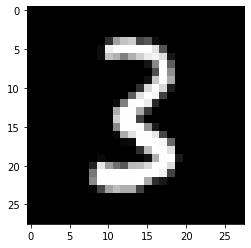

In [182]:
# show the first image in the first batch
plt.imshow(xb[0].view(28,28))
yb[0]

In [183]:
# instantiate model and optimizer
model,opt = get_model()

In [184]:
# refactor fit() using DataLoader class
# training loop
def fit():
    # loop over epochs
    for epoch in range(epochs):
        # loop over batches generated by DataLoader
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [185]:
# train the model for 1 epoch
fit()
# compute loss and accuracy
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1486, grad_fn=<NllLossBackward>), tensor(0.9688))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [186]:
# generator yields indices for random batches from data set
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        # torch.randperm(n) returns a random permutation of integers 0:n-1
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [187]:
# Dataset takes two inputs: *train_ds means pass both elements of train_ds, i.e. the training examples and the labels
small_ds = Dataset(*train_ds[:10])

In [188]:
# first 10 examples and their labels
# print(train_ds[:10])
# print(len(train_ds[:10]))

In [189]:
# sample an epoch of training data in batches with no shuffle, bs = 3
# returns indexes of examples
# note the last batch has only 1 element
s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [190]:
# sample an epoch of training data in batches, with shuffle
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([8, 6, 0]), tensor([1, 5, 9]), tensor([4, 7, 2]), tensor([3])]

In [191]:
# sample an epoch of training data in batches again, with shuffle
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([0, 9, 8]), tensor([1, 3, 6]), tensor([7, 4, 5]), tensor([2])]

In [192]:
def collate(b):
    # returns a batch dataset in the form of tuples of x and y
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

# refactor DataLoader()
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        # this is an iterator that yields batches
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [193]:
# zip returns the xs and ys of a batch in tuples of tensors
xs,ys = zip(*small_ds)
print(len(xs),len(ys))
print(type(xs))
print(ys)

10 10
<class 'tuple'>
(tensor(5), tensor(0), tensor(4), tensor(1), tensor(9), tensor(2), tensor(1), tensor(3), tensor(1), tensor(4))


In [194]:
# collate stacks the tuples xs and ys of a batch into single tensors 
xx, yy = collate(small_ds)
print(len(xx),len(yy))
print(type(yy))
print(yy)

10 10
<class 'torch.Tensor'>
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


In [195]:
# make a random sampler for the training set, and a non-random sampler for the validation set
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [196]:
# make data loaders
# sampler and collate are the keywords, train_samp and collate are the values
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

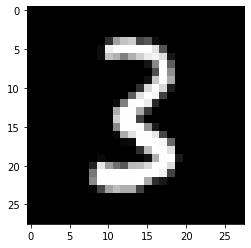

In [197]:
# get a batch from the validation data and show the first image
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(3)

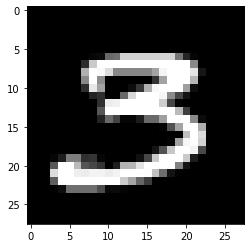

In [198]:
# draw a random batch from the training data
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(1)

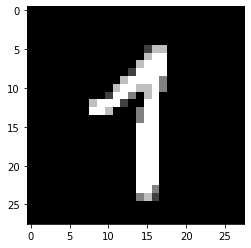

In [199]:
# draw another random batch from the training data
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [200]:
# instantiate the model and train it for a single epoch
model,opt = get_model()
fit()
# loss function and accuracy
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1202, grad_fn=<NllLossBackward>), tensor(0.9531))

### PyTorch DataLoader

In [201]:
# export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [202]:
# use pytorch to build data loaders
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [203]:
# her is how to draw a random batch from train_dl
xb,yb = next(iter(train_dl))

In [204]:

model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.6544, grad_fn=<NllLossBackward>), tensor(0.8125))

PyTorch's defaults work fine for most things however:

In [205]:
# drop the last (partial) batch?
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [206]:
# draw a random batch
xb,yb = next(iter(train_dl))

In [207]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.1636, grad_fn=<NllLossBackward>), tensor(0.9375))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

## Validation

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [208]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # training phase: handle batchnorm / dropout
        model.train()
        # print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        # inference phase
        model.eval()
        # print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

`get_dls` returns dataloaders for the training and validation sets:

In [209]:
#export 
# note double batch size for validation data set, since it needs less storage because it has no gradients 
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [210]:
# make the data loaders
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
# instantiate model and optimizer
model,opt = get_model()
# run the model for 5 epochs, compute loss and accuracy
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.1538) tensor(0.9553)
1 tensor(0.2477) tensor(0.9290)
2 tensor(0.1209) tensor(0.9663)
3 tensor(0.3710) tensor(0.8844)
4 tensor(0.2070) tensor(0.9464)


In [211]:
assert acc>0.9

## Export

In [212]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp\nb_03.py
